Intro. 
I had problems finding correlation between variables and target variable 'Loan_Status'. Dealing with outliers and nan values should help to fix this probelm. 

When removing outliers or nan values, as per *[Good Data Analysis](https://developers.google.com/machine-learning/guides/good-data-analysis)*, we should always explain the reasons why certain parameters should be removed from the analysis. 

Goal:
Remove outliers and deal with nan values.

In [1]:
# Import all the libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")  # Sleek dark background
sns.set_palette(sns.color_palette("Spectral"))  # Color palette

# Load the data
data = pd.read_csv('../data/raw/Loan_Default.csv')

In [2]:
# Identify columns with missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Calculate the percentage of missing values
missing_percentage = (missing_values / len(data)) * 100

# Print summary
print(f"Number of columns with missing values: {len(missing_values)}\n")
print("Columns with NaN values and their count:\n")
for col, count in missing_values.sort_values(ascending=False).items():
    print(f"{col} (*{data[col].dtype}*): {count} ({missing_percentage[col]:.2f}%)")


Number of columns with missing values: 14

Columns with NaN values and their count:

Upfront_charges (*float64*): 39642 (26.66%)
Interest_rate_spread (*float64*): 36639 (24.64%)
rate_of_interest (*float64*): 36439 (24.51%)
dtir1 (*float64*): 24121 (16.22%)
property_value (*float64*): 15098 (10.16%)
LTV (*float64*): 15098 (10.16%)
income (*float64*): 9150 (6.15%)
loan_limit (*object*): 3344 (2.25%)
approv_in_adv (*object*): 908 (0.61%)
age (*object*): 200 (0.13%)
submission_of_application (*object*): 200 (0.13%)
loan_purpose (*object*): 134 (0.09%)
Neg_ammortization (*object*): 121 (0.08%)
term (*float64*): 41 (0.03%)


## Missing Values Analysis

### Key Insights:
- Categorical columns (`object` types) have relatively few missing values, with the worst being just **2.25%**.
- For numerical columns, we need to check their distribution (histograms). This will help decide whether to **impute** missing values (e.g., using mean/median) or handle them another way.
- For categorical columns (object type), we can **safely drop rows** with missing values since they only account for **3.32% of the data**, which is negligible.

### Additional Considerations:
- If numerical data is missing **at random**, imputation might work well.
- If missing values indicate something meaningful (e.g., missing income means zero income), we should **encode them accordingly**.



In [3]:
# Drop NaN values only from object (categorical) columns
data.dropna(subset=data.select_dtypes(include='object').columns, inplace=True)

# Let's also remove nan values from `term` column for the same reason
data.dropna(subset=['term'], inplace=True)

In [4]:
# 0 in Income could mean 0 income instead of missing value lets check missing values from the Income column
missing_income = data[data['income'] == 0].shape[0]
print(f"\nNumber of rows with 0 income: {missing_income}") # There are 1233 rows with 0 income


Number of rows with 0 income: 1233


In [5]:
# Get column names with missing values
missing_columns = data.columns[data.isnull().any()]
assert len(missing_columns) == 7, f"Columns with missing values: {missing_columns}"

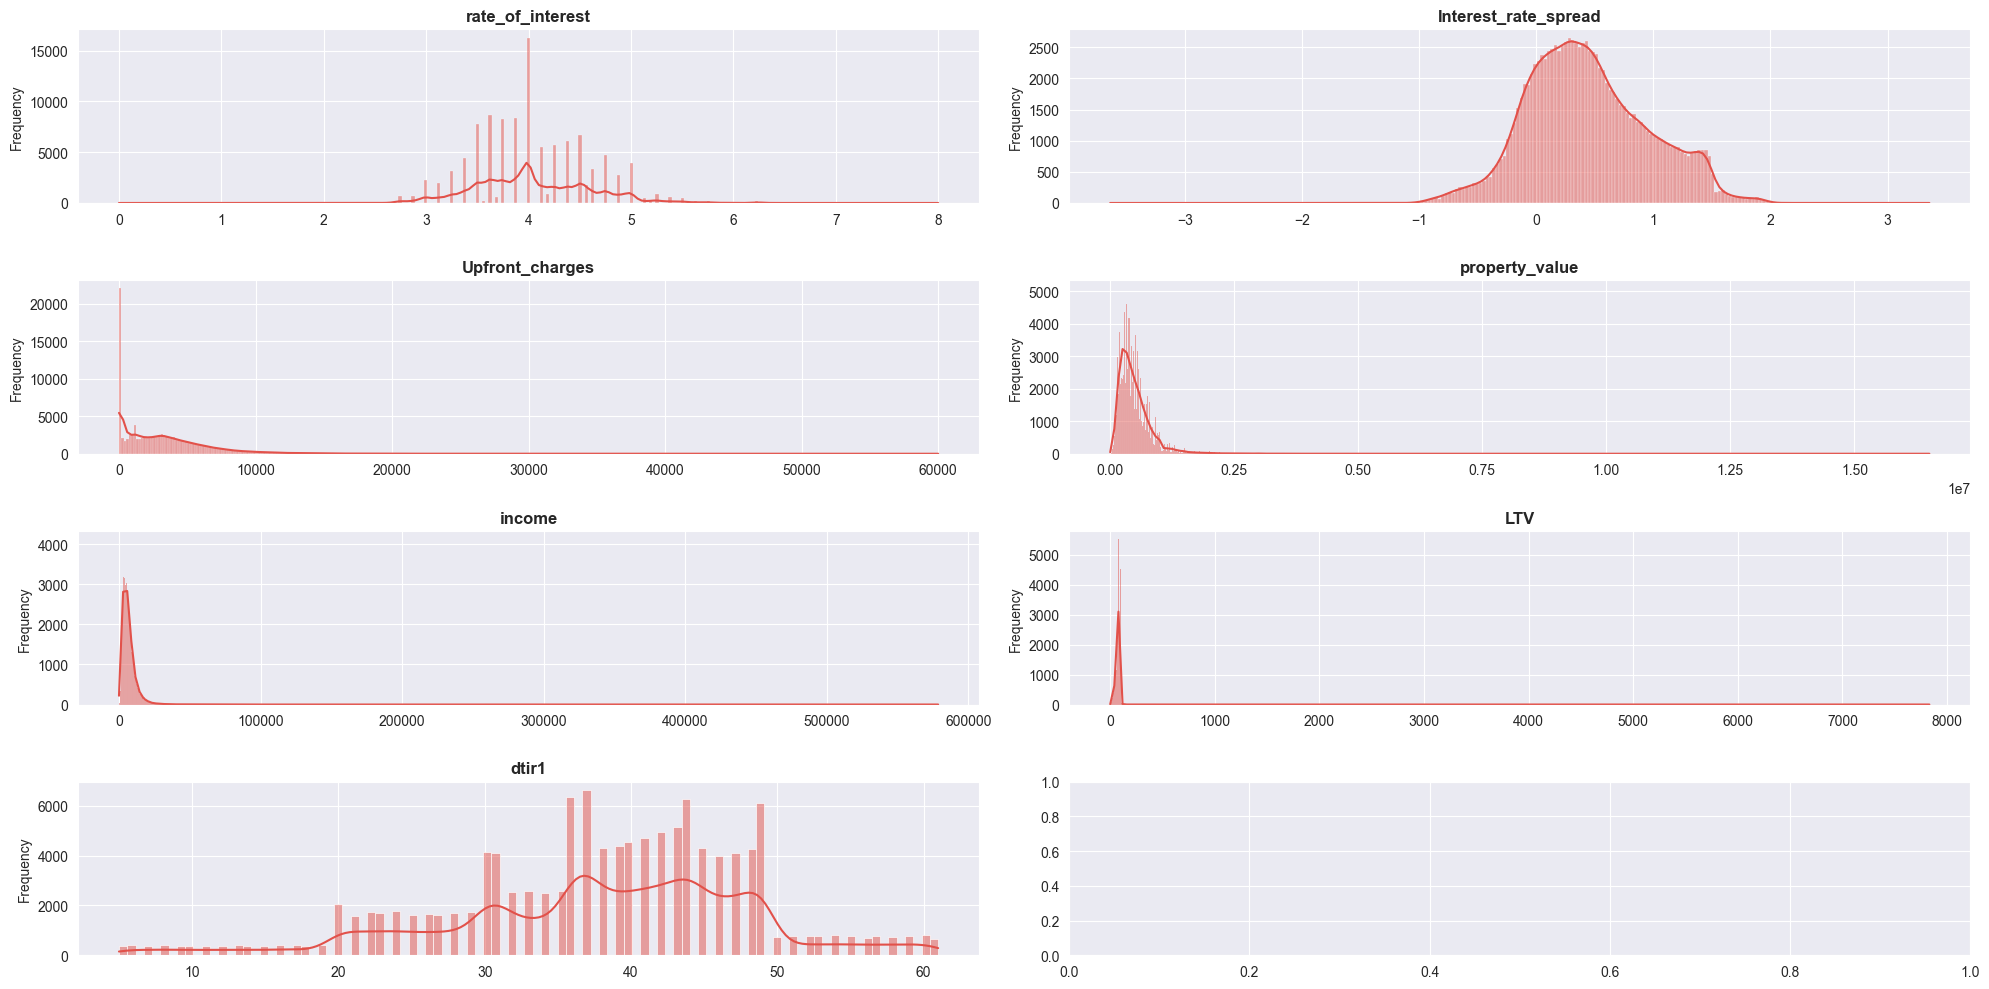

In [6]:
# Plot histograms for the missing columns
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(missing_columns):
    sns.histplot(data[col], ax=axes[i], kde=True)
    axes[i].set_title(f"{col}", fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()


### **Recommended Handling for Missing Values**  

---

### **1. Median Imputation (Best for Skewed Data)**
- **Columns:** `Upfront_charges`, `dtir1`, `property_value`, `income`
- **Reasoning:**  
  - These columns exhibit **right-skewed distributions** with extreme outliers.
  - The **mean** would be affected by outliers, so using the **median** ensures that imputation does not distort the data.
  - Median is a **robust measure** and works well for financial variables.

**Implementation:** Replace missing values with the median of the respective column.

---


<!-- ---

### **3. Predictive Imputation (Optional Advanced Method)**
- **Columns:** `rate_of_interest`, `Interest_rate_spread`
- **Reasoning:**  
  - If we want more precise imputation, we can **predict missing values using regression models**.
  - These features might have a strong correlation with other financial variables.
  - This method works well if we have enough related data.

**Implementation:** Use regression imputation to predict missing values based on other loan-related variables.

---

### **Final Action Plan**
1. **Use median imputation** for highly skewed columns (`Upfront_charges`, `dtir1`, `property_value`, `income`).
2. **Use mean imputation** for normally distributed columns (`Interest_rate_spread`, `rate_of_interest`).
3. (Optional) **Consider regression-based imputation** for `rate_of_interest` and `Interest_rate_spread` if a more data-driven approach is needed. -->



In [7]:
# Median Imputation for columns: Upfront_charges, dtir1, property_value
cols = ['Upfront_charges', 'dtir1', 'property_value']
data[cols] = data[cols].fillna(data[cols].median())

# Median Imputation for 'income', but only if it's NaN (not 0)
data.loc[data['income'].isna(), 'income'] = data['income'].median()

# Ensuring 0s are not affected
print(f"Number of records with zero income: {(data['income'] == 0).sum()}")
print(f"Number of missing values in income after imputation: {data['income'].isnull().sum()}")

Number of records with zero income: 1233
Number of missing values in income after imputation: 0



### **2. Mean Imputation (Best for Normally Distributed Data)**
- **Columns:** `Interest_rate_spread`, `rate_of_interest`
- **Reasoning:**  
  - These features have **approximately normal distributions**.
  - The **mean** is a suitable replacement as it retains the natural variance of the data.
  - Financial rates are typically calculated in a way that small fluctuations around the mean are expected.

**Implementation:** Replace missing values with the mean of the respective column.

In [8]:
# Mean Imputation for columns : Interest_rate_spread, rate_of_interest
# We will use mean imputation for these columns
cols = ['Interest_rate_spread', 'rate_of_interest']
data[cols] = data[cols].fillna(data[cols].mean())

In [9]:
data['LTV']
# Run again to check

0         98.728814
1               NaN
2         80.019685
3         69.376900
4         91.886544
            ...    
148665    71.792763
148666    74.428934
148667    61.332418
148668    70.683453
148669    72.849462
Name: LTV, Length: 143942, dtype: float64

In [10]:
# Let's Recalculate the missing values in LTV
data['LTV'] = (data['loan_amount'] / data['property_value']) * 100

--- 

# Identifying and removing outliers.



In [11]:
# Removing ID column and year column as it is not needed for analysis
data = data.drop(columns=['ID', 'year'], axis=1)  # axis=1 for columns

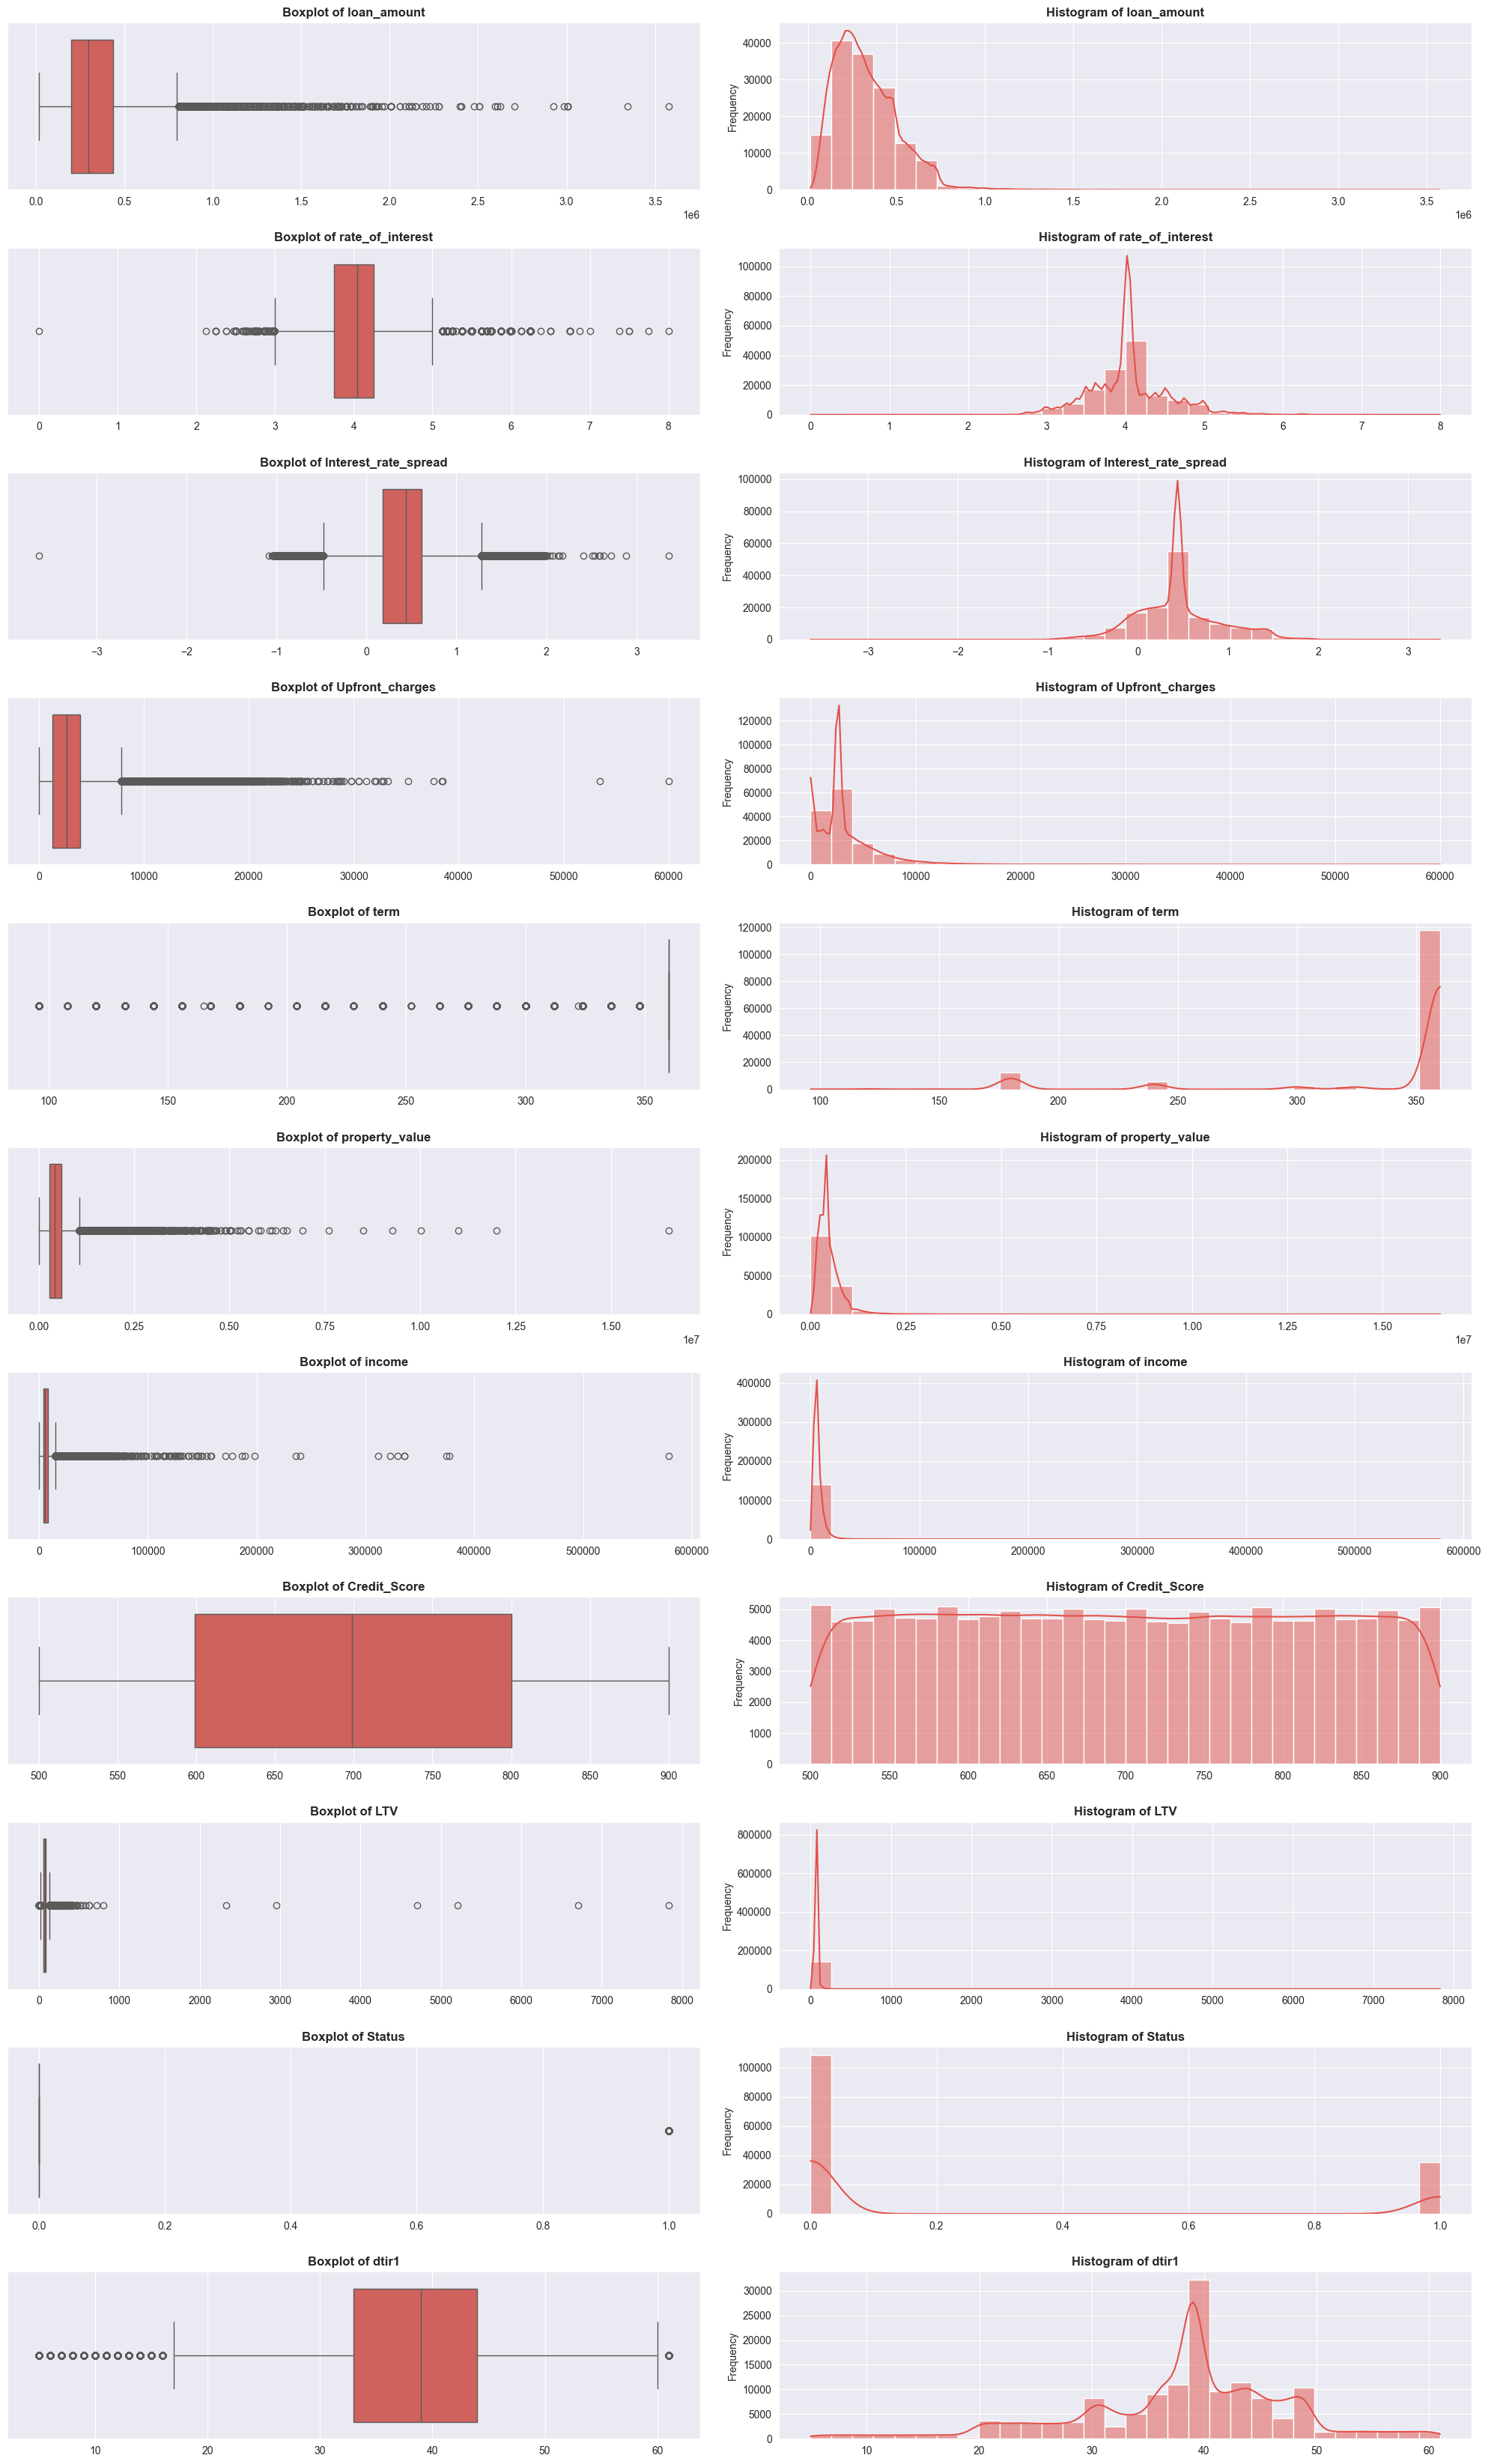

In [12]:
# Select numeric columns
num_cols = data.select_dtypes(include='number').columns

# Set up subplots with two columns (boxplot & histogram)
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(20, 3 * len(num_cols)))

# Loop through numeric columns and plot boxplots and histograms
for i, col in enumerate(num_cols):
    # Boxplot
    sns.boxplot(x=data[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot of {col}", fontweight='bold')
    axes[i, 0].set_xlabel('')

    # Histogram
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histogram of {col}", fontweight='bold')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()
plt.show()


## Highly Skewed Features (Use IQR Method or Winsorization)
> loan_amount, Upfront_charges, property_value,income, LTV
- The histograms show long right tails (positive skewness).
- Using IQR (Interquartile Range) will help remove extreme values without distorting the data.



In [13]:
# Define features based on their distributions
iqr_features = ['loan_amount', 'Upfront_charges', 'property_value', 'income', 'LTV']
zscore_features = ['rate_of_interest', 'Interest_rate_spread']

# Calculate total number of unique outlier rows across all features
outlier_rows = set()

# Step 1.1: Calculate IQR for skewed features
iqr_outliers = {}
for col in iqr_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    iqr_outliers[col] = len(outliers)
    outlier_rows.update(data[(data[col] < lower_bound) | (data[col] > upper_bound)].index)

# Step 1.2: Calculate Z-scores for normally distributed features
zscore_outliers = {}
for col in zscore_features:
    mean = data[col].mean()
    std = data[col].std()
    outliers = data[(data[col] - mean).abs() > 3 * std]
    zscore_outliers[col] = len(outliers)
    outlier_rows.update(data[(data[col] - mean).abs() > 3 * std].index)

# Step 1.3: Combine results into a dataframe
outlier_summary = pd.DataFrame({
    'Feature': iqr_features + zscore_features,
    'Outliers Count': list(iqr_outliers.values()) + list(zscore_outliers.values()),
    'Total Data Points': len(data)
})

# Calculate percentage of outliers per feature
outlier_summary['% Outliers'] = (outlier_summary['Outliers Count'] / outlier_summary['Total Data Points']) * 100
# Calculate percentage of data that would be removed
total_outliers = len(outlier_rows)
total_data_points = len(data)
percentage_removed = (total_outliers / total_data_points) * 100


# Display the summary
print(f'Total percentage of data that would be removed if all outliers were to be removed: {percentage_removed:.2f}%')
print('\nOutlier Summary:')
outlier_summary

Total percentage of data that would be removed if all outliers were to be removed: 15.94%

Outlier Summary:


,Feature,Outliers Count,Total Data Points,% Outliers
0,loan_amount,1863,143942,1.294271
1,Upfront_charges,8614,143942,5.984355
2,property_value,6455,143942,4.484445
3,income,7431,143942,5.162496
4,LTV,3525,143942,2.448903
5,rate_of_interest,858,143942,0.596073
6,Interest_rate_spread,637,143942,0.442539


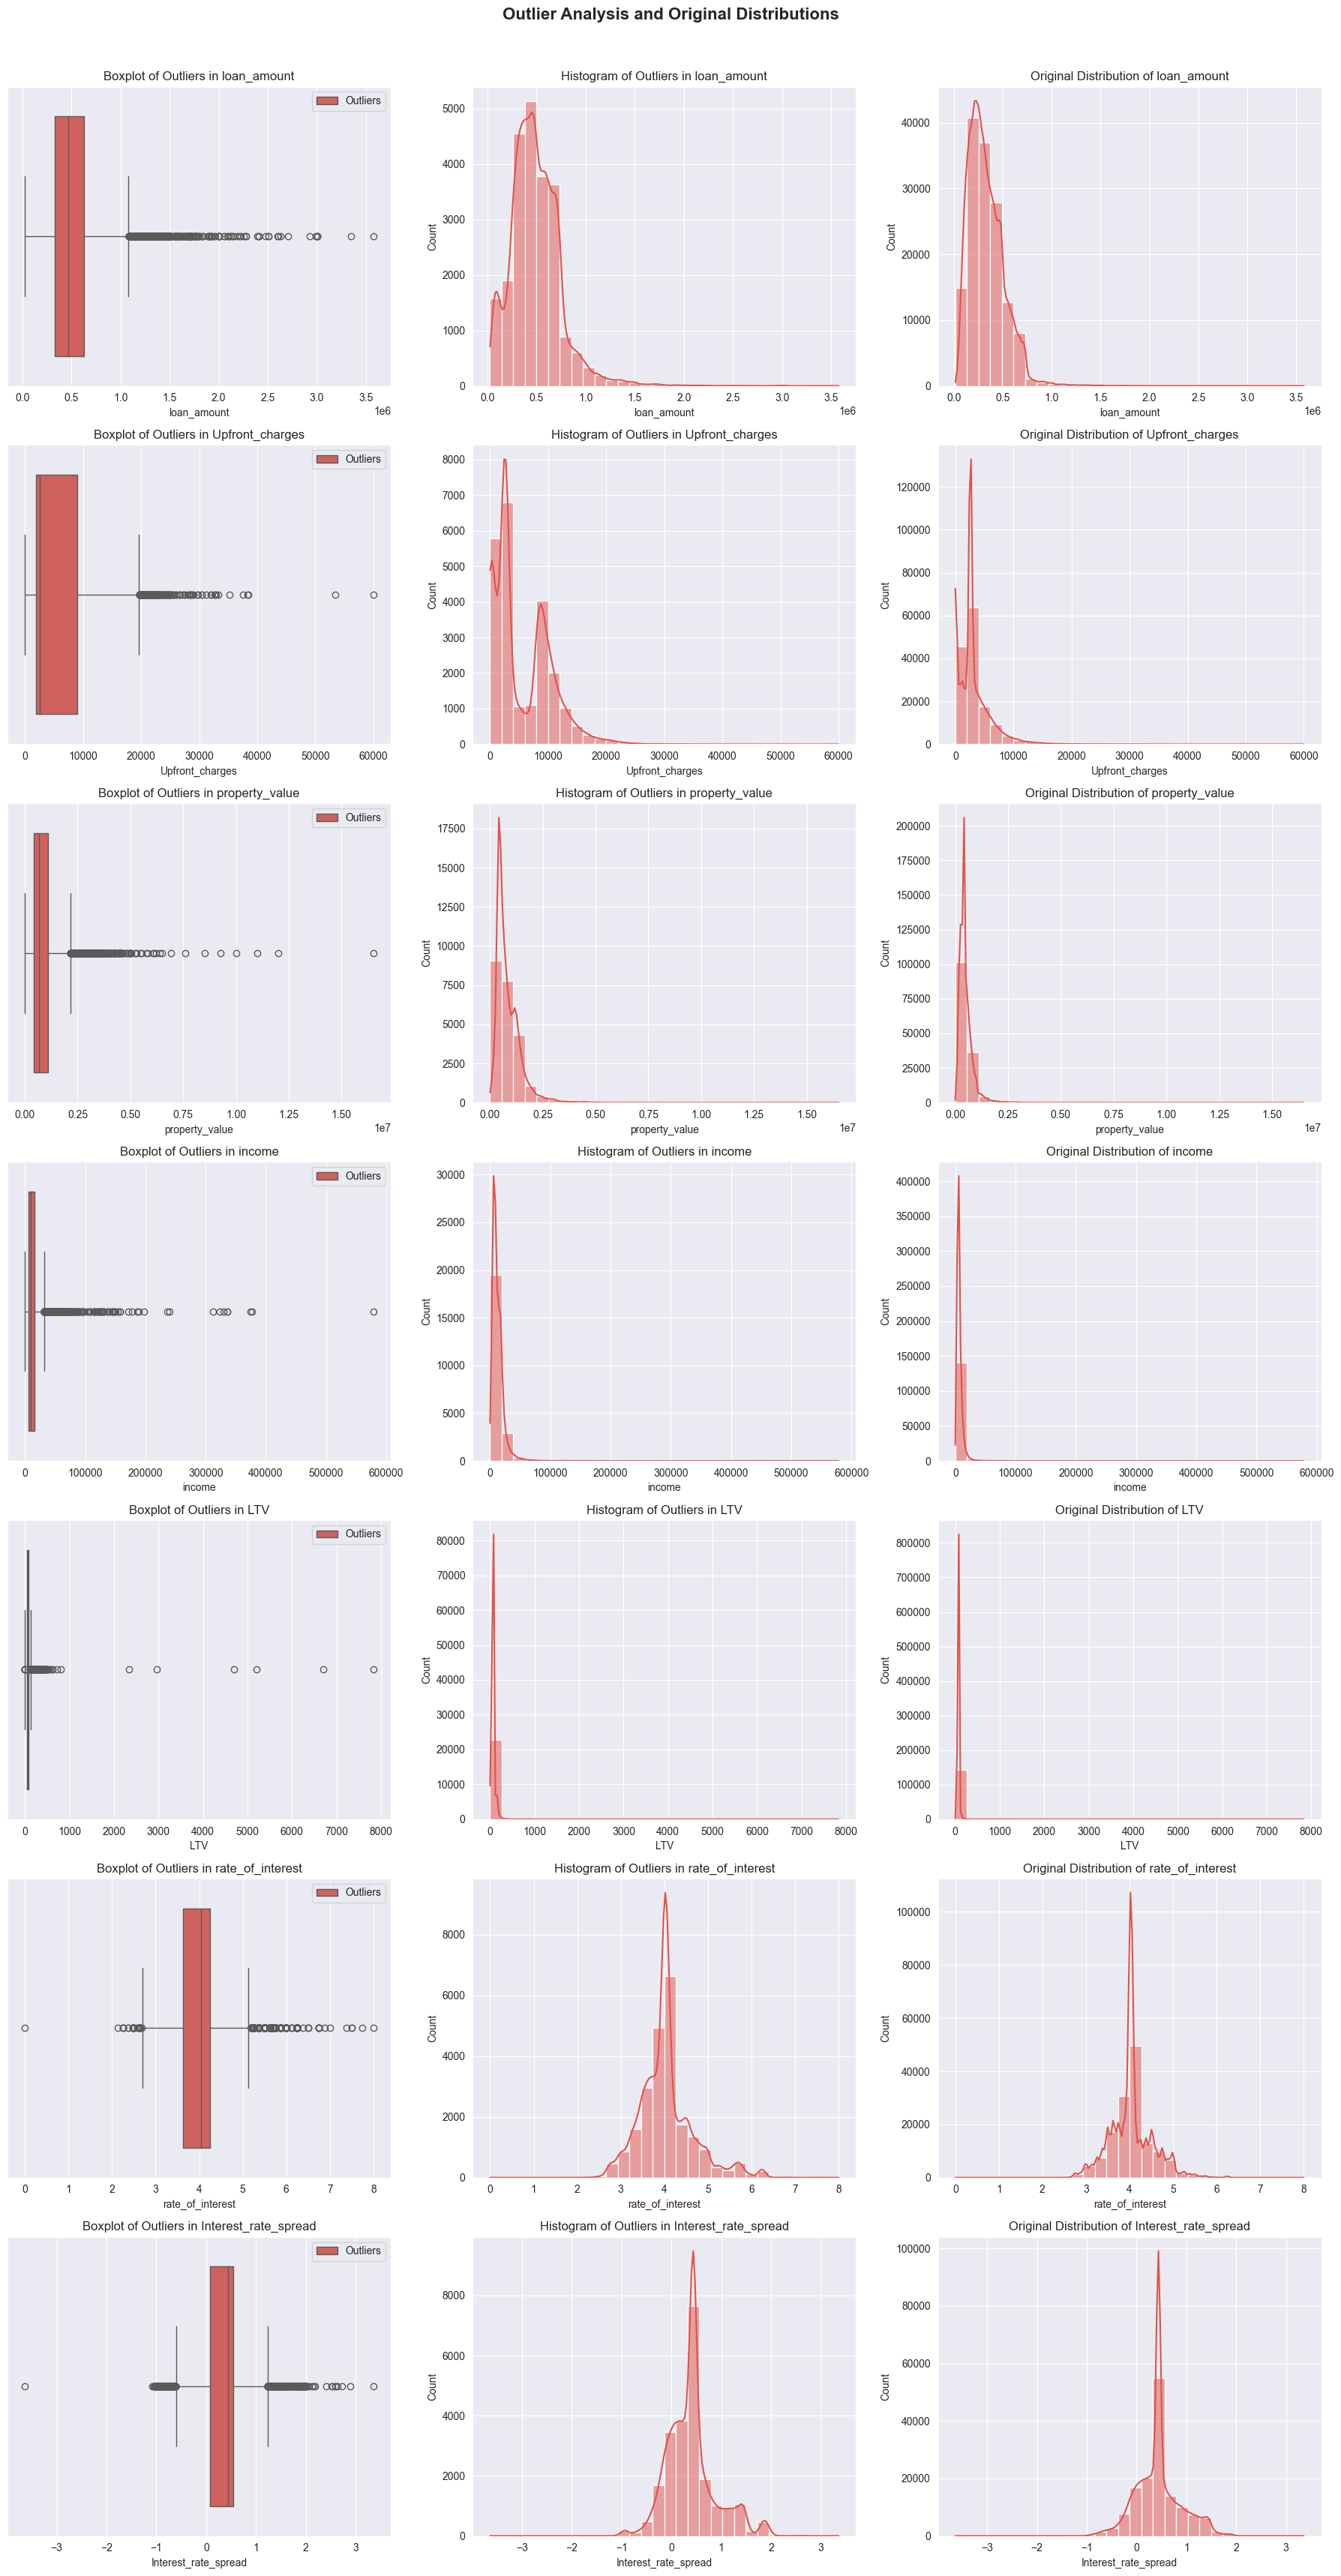

In [14]:
# Create a dataframe with only outlier rows
outlier_df = data.loc[list(outlier_rows)]

# Set up subplots
fig, axes = plt.subplots(nrows=len(iqr_features + zscore_features), ncols=3, figsize=(18, 5 * len(iqr_features + zscore_features)))

# Loop through features and plot distributions
for i, col in enumerate(iqr_features + zscore_features):
    # Boxplot of outliers
    sns.boxplot(x=outlier_df[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot of Outliers in {col}")
    axes[i, 0].legend(['Outliers'], loc='upper right')

    # Histogram of outliers
    sns.histplot(outlier_df[col], kde=True, bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histogram of Outliers in {col}")


    # Histogram of original distribution
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i, 2], )
    axes[i, 2].set_title(f"Original Distribution of {col}")


# Add a main title for the entire figure
fig.suptitle('Outlier Analysis and Original Distributions', fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to make room for the main title
plt.show()

In [15]:
# Define the capping thresholds at 1st and 99th percentiles
cap_thresholds = {}

for col in iqr_features + zscore_features:
    lower_cap = data[col].quantile(0.01)  # 1st percentile
    upper_cap = data[col].quantile(0.99)  # 99th percentile
    cap_thresholds[col] = (lower_cap, upper_cap)

# Apply capping (Winsorization)
df_capped = data.copy()

for col, (lower, upper) in cap_thresholds.items():
    df_capped[col] = np.where(df_capped[col] < lower, lower, df_capped[col])
    df_capped[col] = np.where(df_capped[col] > upper, upper, df_capped[col])

# Count how many values were changed (capped)
capped_values_count = (data != df_capped).sum()

# Calculate percentage of data points affected
capped_percentage = (capped_values_count / len(data)) * 100

# Create a summary dataframe
capping_summary = pd.DataFrame({
    'Feature': capped_values_count.index,
    'Values Capped': capped_values_count.values,
    '% Data Capped': capped_percentage.values
}).sort_values(by='% Data Capped', ascending=False)

# Display the summary of capping
print(f'Capping Summary:')
capping_summary.head(10)

Capping Summary:


,Feature,Values Capped,% Data Capped
10,Interest_rate_spread,2878,1.999416
21,income,2849,1.979269
16,property_value,2826,1.963291
27,LTV,2721,1.890345
8,loan_amount,2502,1.738200
9,rate_of_interest,2147,1.491573
11,Upfront_charges,1440,1.000403
26,submission_of_application,0,0.000000
25,age,0,0.000000
28,Region,0,0.000000


In [16]:
# Lets replot the boxplot and histograms to see the effect of capping
# Set up subplots with three columns (boxplot & histogram)

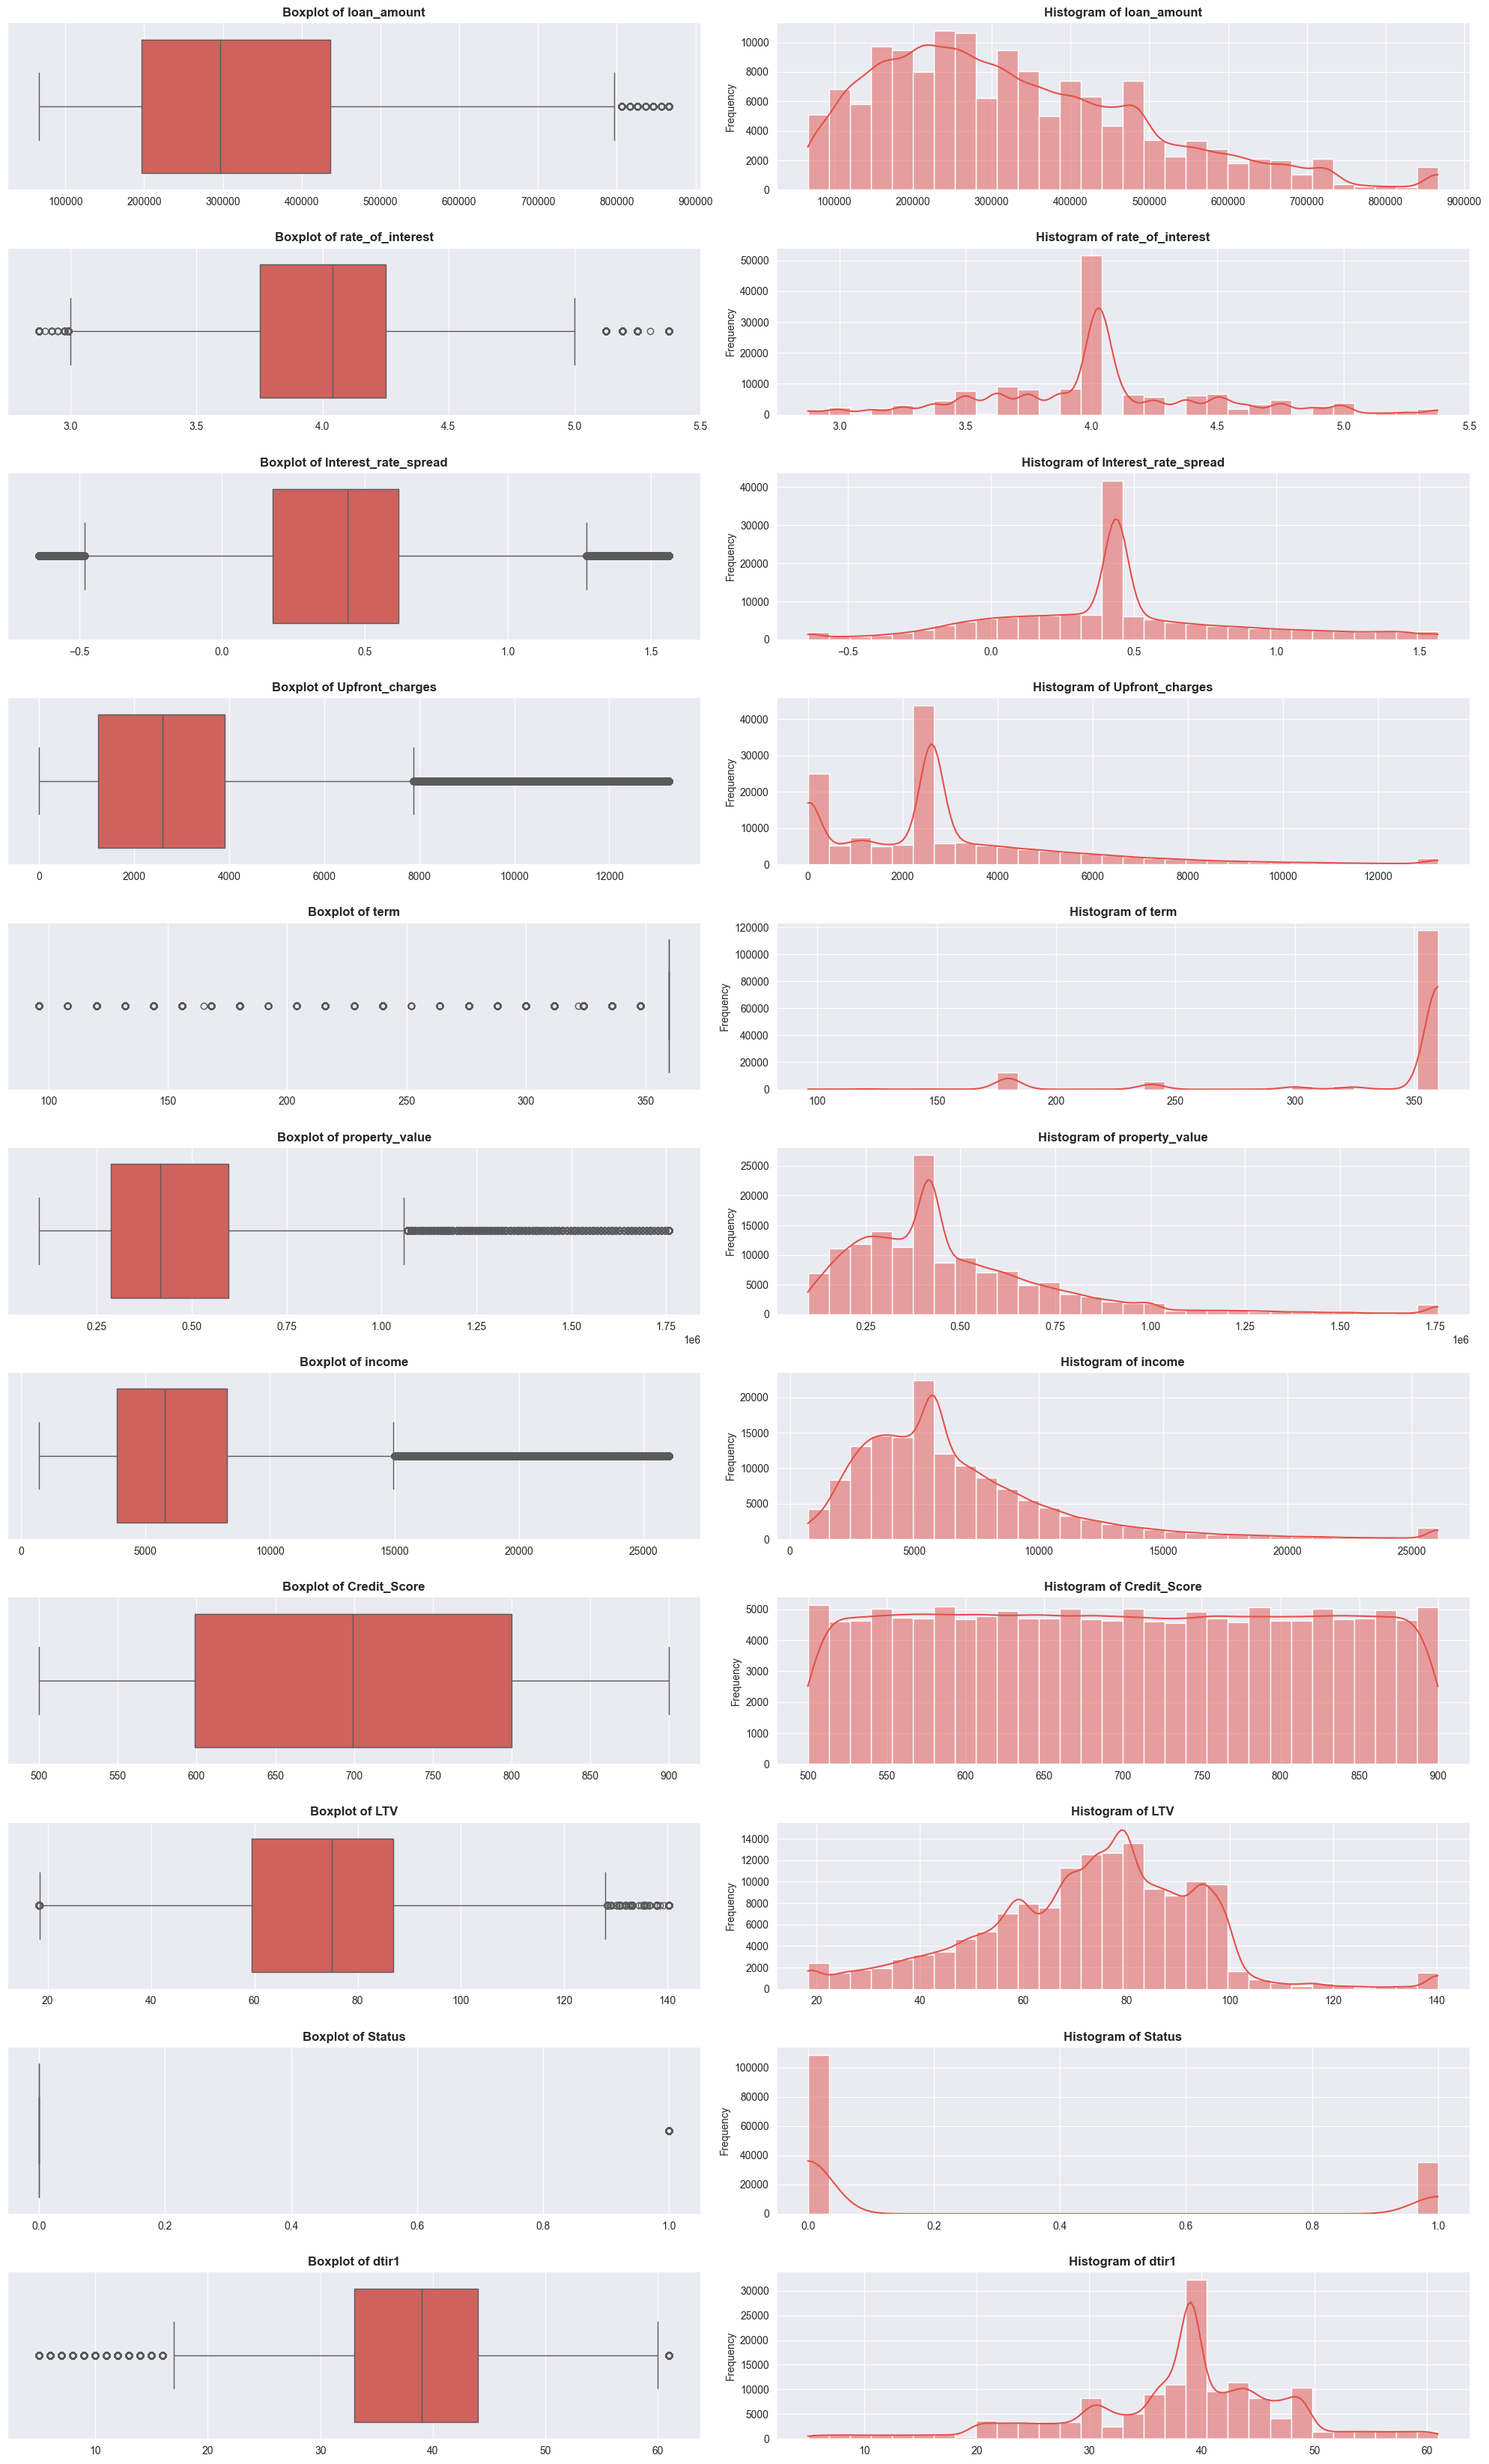

In [17]:
# Lets replot the boxplot and histograms to see the effect of capping
# Select numeric columns
num_cols = data.select_dtypes(include='number').columns
# Set up subplots with two columns (boxplot & histogram)
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(20, 3 * len(num_cols)))

# Loop through numeric columns and plot boxplots and histograms
for i, col in enumerate(num_cols):
    # Boxplot
    sns.boxplot(x=df_capped[col], ax=axes[i, 0] )
    axes[i, 0].set_title(f"Boxplot of {col}", fontweight='bold')
    axes[i, 0].set_xlabel('')

    # Histogram
    sns.histplot(df_capped[col], kde=True, bins=30, ax=axes[i, 1] )
    axes[i, 1].set_title(f"Histogram of {col}", fontweight='bold')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
# Save the cleaned data
df_capped.to_csv('../data/processed/Loan_Default_Cleaned.csv', index=False)